# VASP band structure

**Authors: Rico Häuselmannn, Nicolas Mounet, Giovanni Pizzi (THEOS, EPFL)**

This automatic workflow allows to compute the band structure of a material with a minimal set of input parameters.
It is powered by:
- [VASP](http://www.vasp.at) as the quantum engine
- [AiiDA](http://www.aiida.net) as the automation platform
- [AiiDA-VASP](http://http://aiida-vasp.readthedocs.io/) as the curated pseudopotential family
- Custom-made workflows for AiiDA to manage the selection of parameters, the error handling, ...
- [AppMode for Jupyter](http://github.com/oschuett/jupyter_appmode) to create a simple UI

If you use this tool in your research, please cite [INSERT CITATION HERE]

In [1]:
## TODO
## REPLACE VBOXES with descriptions
#   style = {'description_width': 'initial'}
#  IntSlider(description='A too long description', style=style)

In [2]:
# Main imports for UI
import ipywidgets as ipw
from IPython.display import display, clear_output, HTML, Javascript
from fileupload import FileUploadWidget

In [3]:
import aiida
if not aiida.is_dbenv_loaded():
    aiida.load_dbenv()
from aiida.work import submit, run

In [4]:
#from phonon_turnkey_lib import phonondispersion_functions as ph_fn
import vasp_example as vex
import bands_wf as bwf
import subprocess as sp

In [5]:
warningsbox = ipw.HTML("")

styles = [
    "background-color: rgb(242, 222, 222)",
    "border-color: rgb(235, 204, 209)",
    "border-radius: 4px",
    "border-style: solid",
    "border-width: 1px",
    "font-size: 14px",
    "line-height: 20px",
    "margin: 0px",
    "padding: 10px",
    "padding-left: 20px",
    "padding-right: 20px",    
]

def show_warning(msg):
    """
    Shows a warning in a red box.

    If msg is empty or None, removes the box.
    :param msg: Should be a valid HTML string (this is not validated)
    """
    global warningsbox
    
    if not msg:
        warningsbox.value = ''
    else:
        warningsbox.value = '<div style="{}">WARNING! {}</div>'.format("; ".join(styles), msg)

In [6]:
# An object that can be 'Display'ed to jump back here
js_jump = Javascript("""window.location.href = "#warningsbox";""")

<!-- An anchor for the box rendered in the next cell -->
<a id="warningsbox"></a>

In [7]:
display(warningsbox)
# To use: call #show_warning(msg)

A Jupyter Widget

In [8]:
def nice_errors(default_return=None):
    def decorator(fn):
        def inner_fn(*args, **kwargs):
            try:
                # Clean-up before running the function
                show_warning('')                
                return fn(*args, **kwargs)
            except Exception as e:
                # "Eat" the exception but show an error
                show_warning("Internal error during execution. Error: {}".format(
                    str(e)))
                display(js_jump)
                return default_return
        return inner_fn
    return decorator

In [9]:
structure = None

upload_out = ipw.HTML()

@nice_errors(default_return=None)
def on_file_upload(c):
    global structure, upload_out
    
    from aiida.orm import DataFactory
    StructureData = DataFactory('structure')
    
    import ase, ase.io
    from tempfile import NamedTemporaryFile
    
    upload_out.value = "Uploading structure..."
    tmp = NamedTemporaryFile(suffix=in_file_upload.filename)
    f = open(tmp.name, "w")
    f.write(in_file_upload.data)
    f.close()
    if tmp.name.endswith('.aiida'):
        from aiida.orm.importexport import import_data
        upload_out.value = "Importing data..."
        import_dict = import_data(tmp.name,silent=True)
        qs = StructureData.query(pk__in=[_[1] for _ in import_dict['Node']['existing']+import_dict['Node']['new']])
        if qs.count()==0:
            raise ValueError("No structure found!")
        if qs.count() > 1:
            upload_out.value = "<strong>Number of structures found</strong>: %d; considering only the first one.<br>"%qs.count()
        else:
            upload_out.value = "<strong>Structure loaded.</strong><br>"    
        structure = qs.first()
    else:
        ase_structures = ase.io.read(tmp.name, index=":")
        if len(ase_structures) > 1:
            upload_out.value = "<strong>Number of structures found</strong>: %d; considering only the first one.<br>"%len(ase_structure)
        else:
            upload_out.value = "<strong>Structure loaded.</strong><br>"
        ase_structure = ase_structures[0]
        structure = StructureData(ase = ase_structure)
    tmp.close()
    #update_view()
    upload_out.value += '\nStructure chemical formula: <strong>%s</strong>.' % structure.get_formula()
    
#TODO: FileUploadWidget doesn't fire event when same file is uploaded twice
in_file_upload = FileUploadWidget("Upload Structure")
in_file_upload.observe(on_file_upload, names='data')

in_use_example_structure = ipw.Checkbox(
    value=False,
    description='Use an example structure',
    disabled=False
)

example_structure_options = [['Diamond', 'diamond'], ['Aluminum', 'al'],['GaAs', 'gaas'], ['Cobalt', 'co'], ['Silicon', 'si']]
in_example_structure = ipw.Dropdown(
    options=example_structure_options,
    value=example_structure_options[0][1],
    disabled=True
)

def on_use_example_structure_change(v):
    if v['owner'].value:
        in_file_upload.disabled = True
        in_example_structure.disabled = False
    else:
        in_file_upload.disabled = False        
        in_example_structure.disabled = True

# Setup listener
in_use_example_structure.observe(on_use_example_structure_change, names='value')

structure_group = ipw.VBox(
    [
        in_file_upload,
        upload_out,
        ipw.HBox(
            [
            in_use_example_structure,
            in_example_structure,
            ]),
    ])

def get_example_structure(key):
    from aiida.orm import DataFactory
    from ase.lattice.spacegroup import crystal
    StructureData = DataFactory('structure')
    
    if key == 'diamond':
        # This is the lattice constant in angstrom
        alat = 3.56
        diamond_ase = crystal('C', [(0,0,0)], spacegroup=227,
                          cellpar=[alat, alat, alat, 90, 90, 90],primitive_cell=True)
        s = StructureData(ase=diamond_ase)
        return s
    elif key == 'al':
        # This is the lattice constant in angstrom
        alat = 4.05
        Al_ase = crystal('Al', [(0,0,0)], spacegroup=225,
                          cellpar=[alat, alat, alat, 90, 90, 90],primitive_cell=True)
        s = StructureData(ase=Al_ase)
        return s
    elif key == 'gaas':
        # This is the lattice constant in angstrom
        alat = 5.75
        GaAs_ase = crystal('GaAs', [(0,0,0),(0.25,0.25,0.25)], spacegroup=216,
                          cellpar=[alat, alat, alat, 90, 90, 90],primitive_cell=True)
        s = StructureData(ase=GaAs_ase)
        return s
    elif key == 'co':
        # These are the lattice constants in angstrom
        a = 2.5
        c = 4.07
        Co_ase = crystal('Co', [(1./3,2./3,0.25)], spacegroup=194,
                          cellpar=[a, a, c, 90, 90, 120],primitive_cell=True)
        s = StructureData(ase=Co_ase)
        return s
    elif key == 'si':
        return vex.create_structure_Si()
    else:
        raise ValueError("Unknown or unsupported example structure '{}'".format(key))

def get_structure():
    global structure
    if in_use_example_structure.value:
        structure_key = in_example_structure.value
        return get_example_structure(structure_key)
    else:
        if structure is None:
            raise ValueError("You did not upload a structure. Either upload a structure or choose an example.")
        else:
            return structure

In [10]:
ISIF_options = [['ISIF = 4', 4], ['ISIF = 3', 3]]
in_relax_mode = ipw.RadioButtons(
    options=ISIF_options,
    value=ISIF_options[0][1],
    disabled=False
)

relax_group = ipw.HBox(
    [
        ipw.Label(value="ISIF for Structure relaxation: "), 
        in_relax_mode
    ])

In [11]:
@nice_errors(default_return=None)
def get_code_options(plugin_classes):
    """
    Return AiiDA codes using a specific set of plugins
    
    :param plugin_classes: a dictionary of the type
      {'pw': 'quantumespresso.pw', 'ph': 'quantumespresso.ph'}
      where the key is a label and the value is the plugin to check for.
      It will return the set of codes that exist on the same machine.
    """
    from aiida.orm.querybuilder import QueryBuilder
    from aiida.orm import Code, Computer
    
    # TODO: add filter to show only computers configured
    # by the current user
    
    qb = QueryBuilder()
    qb.append(Computer,
          filters={'enabled': True},
          project='name', tag='computer')
    ordered_tags = []
    for tag, plugin_class in plugin_classes.iteritems():
        ordered_tags.append(tag)
        qb.append(Code,
          filters={'attributes.input_plugin': {'==': plugin_class},
                   'attributes.hidden': {"~==": True}
            },
            project='label', tag='{}code'.format(tag), has_computer='computer')
    all_results = qb.all()
    return [{tag: "{}@{}".format(codename, codeset[0]) for codename, tag in zip(codeset[1:], ordered_tags)} 
            for codeset in all_results]

code_options_full = None
in_codename = ipw.Dropdown(options=get_code_options({'VASP': 'vasp.vasp'}), disabled=True)


code_group = ipw.HBox(
    [
        ipw.Label(value="VASP code to use: "), 
        in_codename,
        ipw.Label(value="Note: only showing code sets that are setup on the same computer"), 
    ])

In [12]:
in_max_num_machines = ipw.IntSlider(
    value=2,
    min=1,
    max=8,
    step=1,
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
max_num_machines_group = ipw.VBox([
        ipw.HBox(
        [
            ipw.Label(value="Maximum number of compute nodes"), 
            in_max_num_machines]
        ),
        ipw.Label(value="Note: putting the value above too high will not make your result come faster, but you will finish your allocation earlier nevertheless..."), 
      ])

In [13]:
# kpoints distance
kpoints_distance_options = [
    ['0.3 (quick estimation)', 0.3],
    ['0.2', 0.2],
    ['0.15 (more accurate)', 0.15],
]
in_kpoints_distance = ipw.Dropdown(
    options=kpoints_distance_options,
    value=0.2
)

kpoints_distance_box = ipw.HBox(
    [
        ipw.Label(value="k-points distance (smaller is slower and more accurate)"), 
        in_kpoints_distance
    ])

In [14]:
in_max_walltime = ipw.IntSlider(
    value=24,
    min=1,
    max=24,
    step=1,
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
max_walltime_group = ipw.HBox(
        [
            ipw.Label(value="Maximum walltime per job (hours)"), 
            in_max_walltime]
        )

In [15]:
# Group options and show them
input_group = ipw.VBox([
    relax_group,
#    in_do_mag,
#    in_do_bands,
#    in_do_phonons,
])
basic_group = ipw.VBox([
#    sssp_group,
    kpoints_distance_box,
])
cpu_group = ipw.VBox([
    code_group,
    #phpostcode_group,
    #max_num_machines_group,
    #target_time_group
])
advanced_group = ipw.VBox([
#    smearing_box,
#    mixingbeta_box,
#    cutofffactor_box,
    max_walltime_group
])
###############################
structure_accordion = ipw.Accordion(children=[
    structure_group,
])
structure_accordion.set_title(0, "Crystal structure")
structure_accordion.selected_index = 0
display(structure_accordion)


input_accordion = ipw.Accordion(children=[
    input_group,
])
input_accordion.set_title(0, "Main input")
input_accordion.selected_index = 0
display(input_accordion)

cpu_accordion = ipw.Accordion(children=[
    cpu_group,
])
cpu_accordion.set_title(0, "Computers, codes and parallelization")
cpu_accordion.selected_index = 0
display(cpu_accordion)

basic_accordion = ipw.Accordion(children=[
    basic_group,
])
basic_accordion.set_title(0, "Basic numerical options")
basic_accordion.selected_index = 0
display(basic_accordion)

# I create two independent accordions, with one child each, so we can keep them both open
advanced_accordion = ipw.Accordion(children=[
    advanced_group,
])
advanced_accordion.set_title(0, "Advanced options")
# Collapsed by default
advanced_accordion.selected_index = None
display(advanced_accordion)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [16]:
# This will be used (and displayed) later to show the output of the validator
validator_out = ipw.Output()

In [17]:
from aiida.work.db_types import Int, Float, Str
def validate():
    
    generated_input = {}
    generated_input['relax_ISIF'] =  Int(in_relax_mode.value)
    generated_input['relax_kpts_dist'] = Float(in_kpoints_distance.value)
    #generated_input['automatic_parallelization'] = {
    #    'max_num_machines': in_max_num_machines.value,
    #    'target_time_seconds': in_target_time.value * 3600,
    #    'max_wall_time_seconds': in_max_walltime.value * 3600
    #}
    if in_codename.value is None:
        raise ValueError("No VASP codes have been specified...") 
    generated_input['vasp_codename'] = Str(in_codename.value['VASP'])
    generated_input['structure'] = vex.new_or_existing_structure(get_structure())
    
    return generated_input 
    
    
    #global in_SSSP_type
    #print in_SSSP_type.value
    #if in_SSSP_type.value == "Efficiency":
    #    pass
    #else:
    #    raise ValueError("Unsupported value for the SSSP group")

In [18]:
vex = reload(vex)
bwf = reload(bwf)
@nice_errors(default_return=None)
def run_wf(inputs):
    return run(bwf.ExampleWorkflow, **inputs)

@nice_errors(default_return=None)
def submit_wf(inputs):
    return submit(bwf.ExampleWorkflow, **inputs)

In [19]:
validate_button = ipw.Button(
    description='Validate input',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    #tooltip='',
    icon='check'
)
run_button = ipw.Button(
    description='Run workflow with validated input',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    #tooltip='',
    icon='play',
    layout=ipw.Layout(width='initial'), # Full width of the button
)

wf_out_bands = ipw.Image(format='png')

#kill_button = ipw.Button(
#    description='Kill all jobs',
#    disabled=True,
#    button_style='danger', # 'success', 'info', 'warning', 'danger' or ''
#    #tooltip='',
#    icon='stop'
#)

## Now empty, will be filled with run_button by the validator
run_box = ipw.HBox(
    [
    ])

## Now empty, will be filled after run_button is clicked
wf_status_box = ipw.VBox(
    [
    ])


latest_validated_data = None

def on_validate(b):
    global run_button, run_box, latest_validated_data
    
    b.disabled = True
    run_box.children = []
    
    try:
        validator_out.clear_output()
        latest_validated_data = validate()
    except ValueError as e:
        show_warning(str(e))
        display(js_jump)
    else:
        # Validated ok
        run_box.children = [run_button]
        with validator_out:
            display(ipw.HTML("<strong>general parameters</strong>"))
            display({k: v for k, v in latest_validated_data.items() if k != 'structure'})
            display(ipw.HTML("<strong>structure</strong>"))
            display(latest_validated_data['structure'])
            display(ipw.Label("Cell"))
            display(latest_validated_data['structure'].cell)
            display(ipw.Label("Sites"))
            display(latest_validated_data['structure'].sites)
    finally:
        # Re-enable anyway button
        b.disabled = False
    
validate_button.on_click(on_validate)

def on_run(b):
    from matplotlib import pyplot as plt
    global validate_button, wf_status_box, latest_validated_data
    #global kill_button
    validate_button.disabled = True
    b.disabled = True
    #kill_button.disabled = False
    
    ## We run the WF!
    wf_info = run_wf(latest_validated_data)
    
    files = wf_info['bands'].export('bands.png', fileformat='mpl_png', overwrite=True)
    from py.path import local
    img_path = local(files[0])
    wf_out_bands.value=img_path.read()
    
    wf_status_box.children = [wf_out_bands]
    
    ## We try to run the WF and it fails
    # wf_info = submit_wf(latest_validated_data)
    #
    # img_path = local(files[0])
    # wf_out_status = ipw.Textarea()
    # wf_out_status.disabled = True
    #
    # wf_status_box.children = [wf_out_status]
    #
    # workcalc = load_node(wf_info.pid)
    # while not workcalc.has_finished() and not workcalc.has_aborted():
    
    
    ## Now, we show some links (if all went well)
    #if wf_info is not None:
    #    wf_status_box.children = [
    #        ipw.HTML("The workflow was run with <strong>workflow ID = {}</strong>. Please note down this number for future reference.".format(wf_info.pid)),
    #        ipw.HTML('<a target="_blank" href="phonon%20status%20monitor.ipynb?wf_pk={0}">Monitor the status and check results of workflow {0}</a>.'.format(wf_info.pid)),
    #        ]
    
run_button.on_click(on_run)

#def on_kill(b):
#    global run_button, validate_button
#    validate_button.disabled = False
#    b.disabled = True
#    run_button.disabled = True
#    print 'Killing not implemented yet!'    
#kill_button.on_click(on_kill)

display(ipw.HBox(
    [
        validate_button,
        #run_button,
        #kill_button       
    ]))

display(ipw.HBox(
    [
        validator_out,
        #kill_button       
    ]))

display(run_box)
display(wf_status_box)
#display(wf_out_bands)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

<IPython.core.display.Javascript object>

In [21]:
from aiida.orm import load_node
w = load_node(2612)

In [22]:
w

<WorkCalculation: uuid: e0512cbd-7a99-4f16-bf13-a4c4d73a8960 (pk: 2612)>

In [23]:
w.has_finished_ok()

True

In [24]:
w.get_attrs()

{u'_finished': True, u'_process_label': u'ExampleWorkflow', u'_sealed': True}

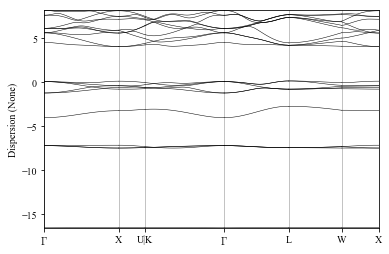

In [25]:
w.out.bands.show_mpl()